In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("/Users/benediktas/dev/University/data-science/tennis/tennis_atp/tennis_atpatp_matches_combined.csv")
df.columns

df_clean = df.dropna(subset=["loser_rank", "winner_rank", "w_ace", "l_ace","w_df", "l_df", "w_1stWon", "w_1stIn", "w_bpFaced", "l_bpFaced"]).copy()

df_clean.shape

(97125, 49)

In [3]:
df_clean["rank_gap"] = df_clean["loser_rank"] - df_clean["winner_rank"]
df_clean["ace_diff"] = df_clean["w_ace"] - df_clean["l_ace"]
df_clean["df_diff"] = df_clean["w_df"] - df_clean["l_df"]
df_clean["pressure"] = df_clean["w_bpFaced"] - df_clean["l_bpFaced"]
df_clean["serve_load"] = df_clean["w_svpt"] - df_clean["l_svpt"]

In [4]:
mask_1st = df_clean["w_1stIn"] > 0 #only get values where the winner landed a 1st serve
df_clean.loc[mask_1st, "first_serve_win"] = df_clean["w_1stWon"] / df_clean["w_1stIn"]
df_clean.loc[~mask_1st, "first_serve_win"] = np.nan

In [5]:
features = ["rank_gap", "ace_diff", "df_diff", "pressure", "serve_load", "first_serve_win"]

In [6]:
corrs = {}
for f in features:
    corr_value = df_clean[[f, "minutes"]].dropna().corr().iloc[0, 1]
    corrs[f] = corr_value
corrs

{'rank_gap': np.float64(-0.074819168151882),
 'ace_diff': np.float64(-0.06203497011543223),
 'df_diff': np.float64(0.05721235345754132),
 'pressure': np.float64(0.15908015150300348),
 'serve_load': np.float64(0.0172812180407027),
 'first_serve_win': np.float64(-0.2811048165508295)}

In [7]:
corr_df = (
    pd.Series(corrs, name="corr")
      .to_frame()
      .assign(abs_corr=lambda d: d["corr"].abs())
      .sort_values("abs_corr", ascending=False)
      .reset_index()
      .rename(columns={"index": "feature"})
)

print(corr_df.to_string(index=False))


        feature      corr  abs_corr
first_serve_win -0.281105  0.281105
       pressure  0.159080  0.159080
       rank_gap -0.074819  0.074819
       ace_diff -0.062035  0.062035
        df_diff  0.057212  0.057212
     serve_load  0.017281  0.017281


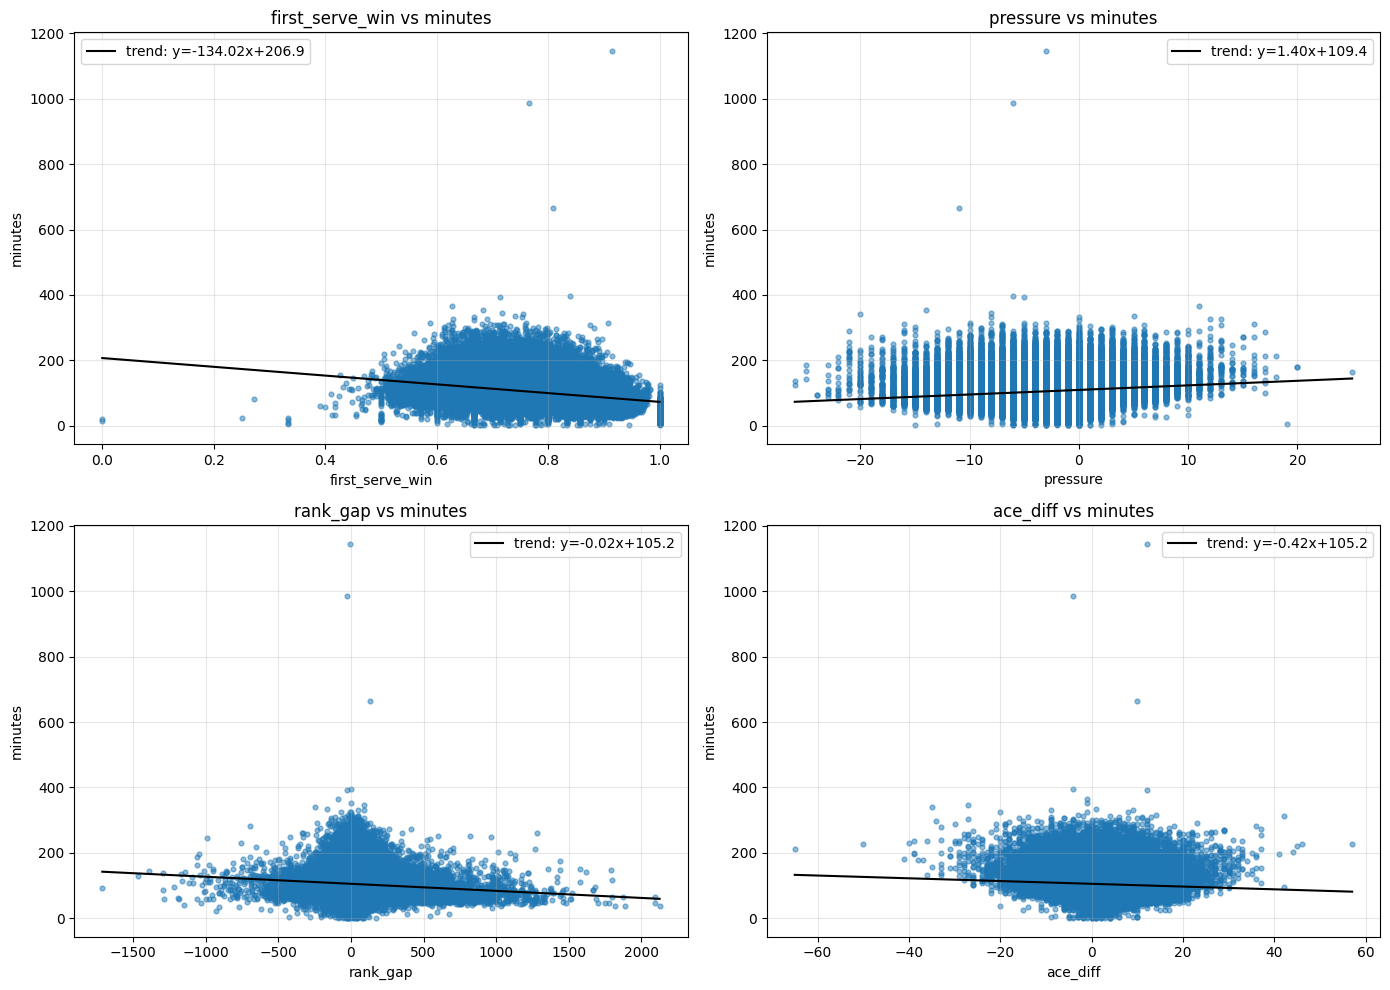

In [ ]:
def scatter_with_trend(df, x_col, y_col="minutes", title=None):
    d = df[[x_col, y_col]].dropna().copy()
    if d.empty:
        print(f"No data to plot for {x_col}.")
        return
    x = d[x_col].values
    y = d[y_col].values

    a, b = np.polyfit(x, y, 1)
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = a * x_line + b

    ax.scatter(x, y, s=12, alpha=0.5)
    ax.plot(x_line, y_line, color="black", linewidth=1.5, label=f"trend: y={a:.2f}x+{b:.1f}")
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(title or f"{x_col} vs {y_col}")
    ax.legend()
    ax.grid(True, alpha=0.3)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

top_features = corr_df["feature"].head(4).tolist()
for idx, f in enumerate(top_features):
    scatter_with_trend(axes[idx], df_clean, x_col=f, y_col="minutes", title=f"{f} vs minutes")

plt.tight_layout()
plt.show()